In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [3]:
df = pd.read_csv("/mnt/data/ML-Ready_clean/mixed_data/output/final-vit-results.csv")

In [ ]:
df2 = pd.read_csv("/mnt/data/ML-Ready_clean/mixed_data/output/SolO-171-304-vit-results.csv")

In [ ]:
df3 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/testing.csv")

In [ ]:
print(df.head())

In [ ]:
df['Timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y-%m-%dT%H:%M:%S')
# df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import LogLocator, FormatStrFormatter

plt.style.use('dark_background')
sns.set_palette("husl")

df = df.sort_values(by='Timestamp')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

ax.plot(df['Timestamp'], df['groundtruth'], label='SXR Long (1 - 8 Å)',
        linewidth=3, alpha=1, markersize=5)

# Labels and title
ax.set_xlabel("Timestamp", fontsize=16, labelpad=10)
ax.set_ylabel("SXR Value (W/m²)", fontsize=16, labelpad=10)

# Limits and scale
ax.set_xlim(pd.to_datetime("2023-08-07T18:00:00"), pd.to_datetime("2023-08-08T02:00:00"))
ax.set_ylim([8e-7, 5e-4])
ax.set_yscale('log')

# Major ticks
ax.set_yticks([1e-6, 1e-5, 1e-4])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))

# Minor ticks - Fixed version
minor_locator = LogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100)
ax.yaxis.set_minor_locator(minor_locator)

# Style minor ticks AFTER setting locator
ax.tick_params(axis='y', which='minor', length=5, width=1, color='white', labelsize=10)

# Style major ticks
ax.tick_params(axis='x', labelsize=16, length=8, width=2)
ax.tick_params(axis='y', which='major', labelsize=16, length=8, width=2)

# Grid - enable minor grid for better visibility
ax.grid(True, alpha=0.3, which='major')
ax.grid(True, alpha=0.1, which='minor')

# Legend
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sort dataframes by timestamp
df = df.sort_values(by='timestamp')
df2 = df2.sort_values(by='timestamp')

# Create the interactive plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=df['timestamp'],
    y=df['predictions'],
    mode='lines+markers',
    name='Predicted SXR - MEGS',
    line=dict(color='skyblue'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>MEGS Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df2['timestamp'],
    y=df2['predictions'],
    mode='lines+markers',
    name='Predicted SXR - Deep-ViT',
    line=dict(color='orange'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>Deep-ViT Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df2['timestamp'],
    y=df2['groundtruth'],
    mode='lines+markers',
    name='Ground Truth SXR',
    line=dict(color='red'),
    marker=dict(symbol='x', size=4, opacity=0.75),
    hovertemplate='<b>Ground Truth</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

# Update layout with dark theme
fig.update_layout(
    width=1600,  # Width in pixels
    height=800,
    title={
        'text': 'SXR Prediction vs Ground Truth (Interactive)',
        'x': 0.5,
        'font': {'size': 16, 'color': 'white'}
    },
    xaxis_title="Timestamp",
    yaxis_title="SXR Value (W/m²)",
    xaxis=dict(
        range=[pd.to_datetime("2023-08-07T00:00:00"), pd.to_datetime("2023-08-09T00:00:00")],
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    yaxis=dict(
        type='log',
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    plot_bgcolor='#2d2d44',
    paper_bgcolor='#1a1a2e',
    font=dict(color='white'),
    legend=dict(
        bgcolor='rgba(0,0,0,0.5)',
        bordercolor='white',
        borderwidth=1
    )
)

# Enable range slider and range selector for easy time navigation
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1h", step="hour", stepmode="backward"),
                dict(count=6, label="6h", step="hour", stepmode="backward"),
                dict(count=12, label="12h", step="hour", stepmode="backward"),
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
    )
)

# Show the plot
fig.show()

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm, LogNorm
from sunpy.visualization.colormaps import color_tables as ct
from scipy.ndimage import zoom


def load_aia_image(timestamp, aia_dir):
    """Load AIA image for given timestamp"""
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    print(f"Found {len(files)} files matching pattern: {pattern}")
    if files:
        aia_data = np.load(files[0])  # Expected shape: (6, 512, 512)
        return aia_data
    return None

def load_attention_map(timestamp, weight_path):
    """Load attention map for given timestamp"""
    filepath = f"{weight_path}{timestamp}"
    try:
        attention_map = np.loadtxt(filepath, delimiter=",")
        return attention_map
    except Exception as e:
        print(f"Failed to load attention map from {filepath}: {e}")
        return None

def display_images_for_timestamp(timestamp, aia_dir, weight_path):
    """Load and display AIA images with attention heatmap and contours"""
    print(f"\nLoading images for timestamp: {timestamp}")

    aia_data = load_aia_image(timestamp, aia_dir)
    attention_data = load_attention_map(timestamp, weight_path)
    attention_data = zoom(attention_data, (8, 8), order=1)

    if aia_data is None:
        print(f"Could not load AIA image for {timestamp}")
        return
    if attention_data is None:
        print(f"Could not load attention map for {timestamp}")
        return

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']

    #att_vmin = np.percentile(attention_data, 2)
    #att_vmax = np.percentile(attention_data, 98)
    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]

        aia_img = aia_data[i]

        # Plot AIA image
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        #Overlay attention heatmap with AsinhNorm
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm, interpolation='nearest')

        # # Overlay contours
        cont = ax.contour(attention_data, levels=10, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')

        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
display_images_for_timestamp("2023-08-07T00:00:00","/mnt/data/ML-Ready/mixed_data/AIA/test/","/mnt/data/ML-Ready/mixed_data/weights2/")

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio


# Config
aia_dir = "/mnt/data/ML-Ready/mixed_data/AIA/test/" # <-- replace with your actual AIA .npy directory
weight_path = "/mnt/data/ML-Ready/mixed_data/weights/"  # <-- replace with your attention map dir
output_dir = "/mnt/data/ML-Ready/mixed_data/movie/"
output_video = "aia_attention_movie.mp4"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamps (30 min intervals from Aug 1 to Aug 14)
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=30)
timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# Visualization and saving function
def load_aia_image(timestamp):
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    if files:
        return np.load(files[0])
    return None

def load_attention_map(timestamp):
    filepath = f"{weight_path}{timestamp}"
    try:
        return np.loadtxt(filepath, delimiter=",")
    except:
        return None

def generate_frame(timestamp, save_path):
    aia_data = load_aia_image(timestamp)
    attention_data = load_attention_map(timestamp)
    attention_data = zoom(attention_data, (8, 8), order=1)
    if aia_data is None or attention_data is None:
        return False  # skip if either is missing

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']


    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]
        aia_img = aia_data[i]
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm)
        cont = ax.contour(attention_data, levels=7, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(f'Timestamp: {timestamp}', color='white', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    return True

# Create all frames
frame_paths = []
for timestamp in timestamps:
    print(f"Generating frame for {timestamp}...")
    frame_path = os.path.join(output_dir, f"{timestamp}.png")
    success = generate_frame(timestamp, frame_path)
    if success:
        frame_paths.append(frame_path)
    else:
        print(f"Skipped {timestamp} (missing data)")

# Compile into video
with imageio.get_writer(output_video, fps=30) as writer:  # You can adjust fps
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"✅ Movie saved to: {output_video}")

In [ ]:
import os
import glob
import numpy as np
import matplotlib
matplotlib.use('Agg')  # headless backend
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio
from concurrent.futures import ProcessPoolExecutor


# === Register colormaps === #


# === Config === #
AIA_DIR = "/mnt/data/ML-Ready/mixed_data/AIA/test/"
WEIGHT_PATH = "/mnt/data/ML-Ready/mixed_data/weights/"
OUTPUT_DIR = "/mnt/data/ML-Ready/mixed_data/movie/"
OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, "aia_attention_movie.mp4")
os.makedirs(OUTPUT_DIR, exist_ok=True)

WAV_CHANNELS = ['94', '131', '171', '193', '211', '304']

# === Timestamps === #
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=5)

timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# === Determine attention map normalization === #
sample_map = None
for ts in timestamps:
    try:
        sample_map = np.loadtxt(os.path.join(WEIGHT_PATH, ts), delimiter=",")
        break
    except:
        continue

if sample_map is None:
    raise RuntimeError("No valid attention map found.")

ATT_VMIN = np.percentile(sample_map, 2)
ATT_VMAX = np.percentile(sample_map, 98)
ATT_NORM = AsinhNorm(vmin=ATT_VMIN, vmax=ATT_VMAX)


# === Frame Generator (must be top-level for multiprocessing) === #
def generate_frame(timestamp):
    # Re-register colormaps in each process


    aia_pattern = f"{AIA_DIR}/*{timestamp}*"
    aia_files = glob.glob(aia_pattern)
    if not aia_files:
        return None

    try:
        aia_data = np.load(aia_files[0])
        attn_path = os.path.join(WEIGHT_PATH, timestamp)
        attn = np.loadtxt(attn_path, delimiter=",")
    except Exception as e:
        print(f"⚠️ Skipping {timestamp}: {e}")
        return None

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')

    for i in range(6):
        ax = axs[i // 3, i % 3]
        ax.imshow(aia_data[i], cmap=f'sdoaia{WAV_CHANNELS[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attn, cmap='hot', origin='lower', alpha=0.25, norm=ATT_NORM)
        cont = ax.contour(attn, levels=7, colors='red', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f"AIA {WAV_CHANNELS[i]} Å", fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(timestamp, color='white', fontsize=14)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{timestamp}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()
    return out_path


# === Run Multiprocessing === #
if __name__ == '__main__':
    print("🚀 Generating frames...")
    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(generate_frame, timestamps))

    # Filter successful frames
    frame_paths = [r for r in results if r is not None]

    print(f"🎞️ Writing video with {len(frame_paths)} frames...")
    with imageio.get_writer(OUTPUT_VIDEO, fps=5, codec='libx264', format='FFMPEG') as writer:
        for path in frame_paths:
            writer.append_data(imageio.imread(path))

    print(f"✅ Done. Movie saved at: {OUTPUT_VIDEO}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Enhanced version with better log scale handling

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#fig.patch.set_facecolor('#1a1a2e')
#ax.set_facecolor('#2d2d44')

# Create log-spaced bins for better visualization with log scale
log_bins = np.logspace(np.log10(df2['groundtruth'].min()),
                       np.log10(df2['groundtruth'].max()), 50)

log_bins = np.logspace(np.log10(df['groundtruth'].min()),
                       np.log10(df['groundtruth'].max()), 50)

ax[0].hist2d(df['groundtruth'], df['predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

ax[1].hist2d(df2['groundtruth'], df2['predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

#plt.colorbar(label='Count (log scale)')

# Add equality line
min_val = min(df2['groundtruth'].min(), df2['predictions'].min())
max_val = max(df2['groundtruth'].max(), df2['predictions'].max())
ax[0].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)
ax[1].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)

plt.xlabel("Ground Truth SXR")
plt.ylabel("Predicted SXR")
plt.title("SXR Prediction vs Ground Truth (Log-binned 2D Histogram)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
#plt.savefig('sxr_prediction_vs_ground_truth_histogram_mixed.png', dpi=500, bbox_inches='tight',)
plt.show()

In [ ]:
res = pd.read_csv("/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/flaring/forecasting/inference/solar_flare_comparison_results/metrics/performance_comparison.csv")

In [ ]:
res

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Read the CSV file directly
df = res

# Display the first few rows to understand the data structure
print("Data Overview:")
print(df.head(10))
print("\nData Shape:", df.shape)
print("\nUnique Models:")
print(df['Model'].unique())

# Clean the data - separate different types of rows
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]
baseline_models = df[df['Model'].str.contains('Baseline') & ~df['Model'].str.contains('Improvement')]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Uncertainty Visualization - SXR Flux Predictions', fontsize=16, fontweight='bold')

# Generate synthetic SXR flux values for demonstration
np.random.seed(42)
flux_range = np.linspace(1e-8, 1e-4, 100)  # Typical SXR flux range
true_values = flux_range

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot 1: ViT Models - MSE based uncertainty bands
ax1 = axes[0, 0]
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mse = vit_row['MSE'].iloc[0]
        rmse = np.sqrt(mse)  # Standard deviation of errors

        # Create prediction bands (±1 standard deviation)
        upper_bound = true_values + rmse
        lower_bound = true_values - rmse

        # Plot the true line and uncertainty band
        ax1.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax1.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'ViT_{variant}')
        ax1.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax1.set_xlabel('True SXR Flux (μW/m²)')
ax1.set_ylabel('Predicted SXR Flux (μW/m²)')
ax1.set_title('ViT Models - Prediction Uncertainty (MSE-based)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Baseline Models - MSE based uncertainty bands
ax2 = axes[0, 1]
for i, variant in enumerate(variants):
    baseline_row = baseline_models[baseline_models['Model'].str.contains(variant)]
    if not baseline_row.empty:
        mse = baseline_row['MSE'].iloc[0]
        rmse = np.sqrt(mse)

        upper_bound = true_values + rmse
        lower_bound = true_values - rmse

        ax2.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax2.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'Baseline_{variant}')
        ax2.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax2.set_xlabel('True SXR Flux (μW/m²)')
ax2.set_ylabel('Predicted SXR Flux (μW/m²)')
ax2.set_title('Baseline Models - Prediction Uncertainty (MSE-based)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: ViT Models - MAE based uncertainty bands
ax3 = axes[1, 0]
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae = vit_row['MAE'].iloc[0]

        # MAE represents average absolute error, so create bands around ±MAE
        upper_bound = true_values + mae
        lower_bound = true_values - mae

        ax3.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax3.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'ViT_{variant}')
        ax3.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax3.set_xlabel('True SXR Flux (μW/m²)')
ax3.set_ylabel('Predicted SXR Flux (μW/m²)')
ax3.set_title('ViT Models - Prediction Uncertainty (MAE-based)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Baseline Models - MAE based uncertainty bands
ax4 = axes[1, 1]
for i, variant in enumerate(variants):
    baseline_row = baseline_models[baseline_models['Model'].str.contains(variant)]
    if not baseline_row.empty:
        mae = baseline_row['MAE'].iloc[0]

        upper_bound = true_values + mae
        lower_bound = true_values - mae

        ax4.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax4.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'Baseline_{variant}')
        ax4.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax4.set_xlabel('True SXR Flux (μW/m²)')
ax4.set_ylabel('Predicted SXR Flux (μW/m²)')
ax4.set_title('Baseline Models - Prediction Uncertainty (MAE-based)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PREDICTION UNCERTAINTY SUMMARY")
print("="*60)

print("\nViT Models - Expected Prediction Spread:")
for _, row in vit_models.iterrows():
    mse_spread = np.sqrt(row['MSE']) * 2 * 1e6  # ±2σ in μW/m²
    mae_spread = row['MAE'] * 2 * 1e6  # ±MAE in μW/m²
    print(f"{row['Model']}:")
    print(f"  MSE-based spread: ±{mse_spread:.3f} μW/m² (±2σ)")
    print(f"  MAE-based spread: ±{mae_spread:.3f} μW/m²")

print("\nBaseline Models - Expected Prediction Spread:")
for _, row in baseline_models.iterrows():
    mse_spread = np.sqrt(row['MSE']) * 2 * 1e6
    mae_spread = row['MAE'] * 2 * 1e6
    print(f"{row['Model']}:")
    print(f"  MSE-based spread: ±{mse_spread:.3f} μW/m² (±2σ)")
    print(f"  MAE-based spread: ±{mae_spread:.3f} μW/m²")

print("\nInterpretation:")
print("- Narrower bands = more precise predictions")
print("- MSE-based bands show ±1σ uncertainty (68% confidence)")
print("- MAE-based bands show average absolute error range")
print("- Black dashed line = perfect prediction (y=x)")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Read the CSV file directly
df = res

# Display the first few rows to understand the data structure
print("Data Overview:")
print(df.head(10))
print("\nData Shape:", df.shape)
print("\nUnique Models:")
print(df['Model'].unique())

# Clean the data - separate different types of rows
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]
baseline_models = df[df['Model'].str.contains('Baseline') & ~df['Model'].str.contains('Improvement')]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Uncertainty in Log Space - SXR Flux Predictions', fontsize=16, fontweight='bold')

# Define flux ranges for each variant based on flare classes
flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),    # A and B class flares (quiet conditions)
    'C': np.linspace(-6, -5, 50),          # C class flares
    'M': np.linspace(-5, -4, 50),          # M class flares
    'X': np.linspace(-4, -3, 50)           # X class flares
}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{int(10**(log_flux + 8)):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot 1: ViT Models - MSE based uncertainty bands (log space)
ax1 = axes[0, 0]
ax1.plot([-8, -3], [-8, -3], 'k--', alpha=0.5, linewidth=1, label='Perfect Prediction')

for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mse = vit_row['MSE'].iloc[0]
        rmse_log = np.sqrt(mse)  # RMSE in log space

        # Get the specific flux range for this variant
        true_log_values = flux_ranges[variant]

        # Create prediction bands in log space
        upper_bound_log = true_log_values + rmse_log
        lower_bound_log = true_log_values - rmse_log

        # Plot uncertainty band only for this variant's range
        ax1.fill_between(true_log_values, lower_bound_log, upper_bound_log,
                        alpha=0.4, color=colors[i], label=f'ViT_{variant} (σ={rmse_log:.3f})')
        ax1.plot(true_log_values, true_log_values, color=colors[i], linewidth=2, alpha=0.8)

ax1.set_xlabel('True Log₁₀(SXR Flux [W/m²])')
ax1.set_ylabel('Predicted Log₁₀(SXR Flux [W/m²])')
ax1.set_title('ViT Models - Log Space Uncertainty by Flare Class (RMSE)')
ax1.set_xlim(-8, -3)
ax1.set_ylim(-8, -3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add flare class labels on right y-axis

flare_ticks = [-7.5, -7.25, -7, -6.5, -6, -5.5, -5, -4.5, -4, -3.5, -3]
flare_labels = [log_flux_to_class(tick) for tick in flare_ticks]

for ax in [ax1, ax2, ax3, ax4]:
    ax_twin = ax.twinx()
    ax_twin.set_yticks(flare_ticks)
    ax_twin.set_yticklabels(flare_labels)
    ax_twin.set_ylabel('Flare Class')
    ax_twin.set_ylim(-8, -3)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Assuming res is your DataFrame
df = res

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges for each variant based on flare classes
flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{int(10**(log_flux + 8)):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([-8, -3], [-8, -3], 'k--', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]
        true_log_values = flux_ranges[variant]

        upper_bound = true_log_values + mae_log
        lower_bound = true_log_values - mae_log

        ax.fill_between(true_log_values, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'ViT_{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_log_values, true_log_values, color=colors[i], linewidth=2, alpha=0.8)

# Axis settings
ax.set_xlabel('True Log₁₀(SXR Flux [W/m²])')
ax.set_ylabel('Predicted Log₁₀(SXR Flux [W/m²])')
ax.set_title('ViT Models - Log Space Uncertainty by Flare Class (MAE)', fontsize=14, fontweight='bold')
ax.set_xlim(-8, -3)
ax.set_ylim(-8, -3)
ax.legend()
ax.grid(True, alpha=0.3)

# Add subticks (minor ticks)
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='minor', length=4, color='gray')

# Add flare class labels on right y-axis
flare_ticks = [-7.5, -7.25, -7, -6.5, -6, -5.5, -5, -4.5, -4, -3.5, -3]
flare_labels = [log_flux_to_class(t) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(-8, -3)

# Add minor ticks to twin axis
ax_twin.minorticks_on()
ax_twin.yaxis.set_minor_locator(AutoMinorLocator())
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator, LogLocator, FuncFormatter

# Set seaborn style and color palette
plt.style.use('dark_background')
sns.set_palette("husl")

# Assuming res is your DataFrame
df = pd.read_csv("/mnt/data/ML-Ready-mixed/ML-Ready-mixed/solar_flare_comparison_results/90-mc-dropout/metrics/performance_comparison.csv")

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges (in log) and convert to linear scale
log_flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

flux_ranges = {k: 10**v for k, v in log_flux_ranges.items()}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{10**(log_flux + 8):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2a2a3e')

# Log-scale axes (set early)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-8, 1e-3)
ax.set_ylim(1e-8, 1e-3)

# Enable grid BEFORE plotting data and set it behind
ax.grid(True, which='major', alpha=0.3, color='white', linestyle='-', linewidth=0.5)
ax.grid(True, which='minor', alpha=0.15, color='white', linestyle=':', linewidth=0.3)
ax.set_axisbelow(True)  # This ensures grid is behind all other elements

# Perfect prediction line
ax.plot([1e-8, 1e-3], [1e-8, 1e-3], 'k-', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands (in linear scale)
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]

        # Get flux range in linear
        true_flux = flux_ranges[variant]

        # Compute upper/lower bounds in linear space
        upper_bound = 10**(np.log10(true_flux) + mae_log)
        lower_bound = 10**(np.log10(true_flux) - mae_log)

        ax.fill_between(true_flux, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_flux, true_flux, color=colors[i], linewidth=2, alpha=0.8)

# Labels and title
ax.set_xlabel('True SXR Flux [W/m²]')
ax.set_ylabel('Predicted SXR Flux [W/m²]')
ax.set_title('ViT Models - SXR Flux Prediction (MAE)', fontsize=14)
ax.legend()

# Minor ticks
ax.minorticks_on()
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.tick_params(axis='both', which='minor', length=4, color='gray')
ax.tick_params(axis='x', which='minor', length=4, color='gray')  # Ensure x-axis minor ticks

# Flare class labels on right y-axis (still in log space)
flare_ticks = [10**t for t in [-8, -7, -6,  -5,  -4,  -3]]
flare_labels = [log_flux_to_class(np.log10(t)) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yscale('log')
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(1e-8, 1e-3)

# Disable grid on twin axis to prevent interference
ax_twin.grid(False)

# Minor ticks on twin y-axis
ax_twin.minorticks_on()
ax_twin.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray')

# Add minor ticks to x-axis as well
ax_twin.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax_twin.tick_params(axis='x', which='minor', length=4, color='gray')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator, LogLocator, FuncFormatter

# Set seaborn style and color palette
plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})
# Assuming res is your DataFrame
df = pd.read_csv("/mnt/data/ML-Ready-mixed/ML-Ready-mixed/solar_flare_comparison_results/90-mc-dropout/metrics/performance_comparison.csv")

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges (in log) and convert to linear scale
log_flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

flux_ranges = {k: 10**v for k, v in log_flux_ranges.items()}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{10**(log_flux + 8):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2a2a3e')

# Log-scale axes (set early)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-8, 1e-3)
ax.set_ylim(1e-8, 1e-3)

# Enable grid BEFORE plotting data and set it behind
ax.grid(True, which='major', alpha=0.3, color='white', linestyle='-', linewidth=0.5)
ax.grid(True, which='minor', alpha=0.15, color='white', linestyle=':', linewidth=0.3)
ax.set_axisbelow(True)  # This ensures grid is behind all other elements

# Perfect prediction line
ax.plot([1e-8, 1e-3], [1e-8, 1e-3], 'k-', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands (in linear scale)
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]

        # Get flux range in linear
        true_flux = flux_ranges[variant]

        # Compute upper/lower bounds in linear space
        upper_bound = 10**(np.log10(true_flux) + mae_log)
        lower_bound = 10**(np.log10(true_flux) - mae_log)

        ax.fill_between(true_flux, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_flux, true_flux, color=colors[i], linewidth=2, alpha=0.8)

# Labels and title
ax.set_xlabel('True SXR Flux [W/m²]')
ax.set_ylabel('Predicted SXR Flux [W/m²]')
ax.set_title('ViT Models - SXR Flux Prediction (MAE)', fontsize=14)
ax.legend()

# Minor ticks - use explicit approach for log scale
ax.minorticks_on()

# Create explicit minor tick locations for log scale
minor_ticks_x = []
minor_ticks_y = []
for decade in range(-8, -2):  # -8 to -3 (covering our range)
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        tick_val = i * (10 ** decade)
        if 1e-8 <= tick_val <= 1e-3:
            minor_ticks_x.append(tick_val)
            minor_ticks_y.append(tick_val)

ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(minor_ticks_y, minor=True)
ax.tick_params(axis='both', which='minor', length=4, color='gray', width=0.5)

# Flare class labels on right y-axis (still in log space)
flare_ticks = [10**t for t in [-8, -7, -6,  -5,  -4,  -3]]
flare_labels = [log_flux_to_class(np.log10(t)) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yscale('log')
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(1e-8, 1e-3)

# Disable grid on twin axis to prevent interference
ax_twin.grid(False)

# Minor ticks on twin y-axis only (manually set)
ax_twin.minorticks_on()
ax_twin.set_yticks(minor_ticks_y, minor=True)
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray', width=0.5)

plt.tight_layout()
plt.show()

In [ ]:
 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator, LogLocator, FuncFormatter

# Set seaborn style and color palette
plt.style.use('dark_background')
sns.set_palette("husl")

# Assuming res is your DataFrame
df = pd.read_csv("/mnt/data/ML-Ready-mixed/ML-Ready-mixed/solar_flare_comparison_results/90-mc-dropout/metrics/performance_comparison.csv")

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges (in log) and convert to linear scale
log_flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

flux_ranges = {k: 10**v for k, v in log_flux_ranges.items()}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{10**(log_flux + 8):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2a2a3e')

ax.plot([1e-8, 1e-3], [1e-8, 1e-3], 'k-', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands (in linear scale)
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]

        # Get flux range in linear
        true_flux = flux_ranges[variant]

        # Compute upper/lower bounds in linear space
        upper_bound = 10**(np.log10(true_flux) + mae_log)
        lower_bound = 10**(np.log10(true_flux) - mae_log)

        ax.fill_between(true_flux, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_flux, true_flux, color=colors[i], linewidth=2, alpha=0.8)

# Log-scale axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-8, 1e-3)
ax.set_ylim(1e-8, 1e-3)

# Labels and title
ax.set_xlabel('True SXR Flux [W/m²]')
ax.set_ylabel('Predicted SXR Flux [W/m²]')
ax.set_title('ViT Models - SXR Flux Prediction (MAE)', fontsize=14)
ax.legend()
#ax.grid(True, which='major', alpha=0.15)

# Minor ticks
ax.minorticks_on()
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.tick_params(axis='both', which='minor', length=4, color='gray')

# Flare class labels on right y-axis (still in log space)
flare_ticks = [10**t for t in [-8, -7, -6,  -5,  -4,  -3]]
flare_labels = [log_flux_to_class(np.log10(t)) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yscale('log')
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(1e-8, 1e-3)

# Minor ticks on twin y-axis
ax_twin.minorticks_on()
ax_twin.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [ ]:
def load_aia_image(timestamp):
    """Load AIA image for given timestamp"""
    pattern = f"/mnt/data/ML-Ready-mixed/ML-Ready-mixed/AIA/test/{timestamp}*"
    files = glob.glob(pattern)
    if files:
        return np.load(files[0])
    return None

In [ ]:
def load_attention_map(timestamp):
    """Load attention map for given timestamp"""
    filepath = os.path.join("/mnt/data/ML-Ready-mixed/ML-Ready-mixed/vit-90epoch", f"{timestamp}")
    try:
        attention = np.loadtxt(filepath, delimiter=",")
        target_shape = [512, 512]
        zoom_factors = (target_shape[0] / attention.shape[0],
                        target_shape[1] / attention.shape[1])
        return zoom(attention, zoom_factors, order=1)
    except Exception as e:
        print(f"Could not load attention map for {timestamp}: {e}")
        return None


In [ ]:
import os
import glob
from multiprocessing import Pool
from datetime import timedelta, datetime

import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from scipy.ndimage import zoom
from matplotlib.colors import AsinhNorm, LogNorm
import seaborn as sns
import matplotlib.ticker as mticker

In [ ]:
att = load_attention_map("2023-08-07T00:01:00")
aia = load_aia_image("2023-08-07T00:01:00")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_vit_patches(aia_data, wavs=['94', '131', '171', '193', '211', '304'], patch_size=16):
    """
    Visualize AIA data with 16x16 patch grid overlay for ViT input demonstration

    Parameters:
    aia_data: numpy array of shape (6, H, W) containing AIA images
    wavs: list of wavelength labels
    patch_size: size of patches (default 16x16)
    """

    # Get dimensions
    n_channels, height, width = aia_data.shape
    n_patches_h = height // patch_size
    n_patches_w = width // patch_size

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'ViT Input: AIA Images with {patch_size}x{patch_size} Patch Grid\n'
                 f'Grid: {n_patches_h}x{n_patches_w} = {n_patches_h * n_patches_w} patches per image',
                 fontsize=14, color='white')
    fig.patch.set_facecolor('black')

    axes = axes.flatten()

    for i in range(6):
        ax = axes[i]

        # Display the AIA image
        im = ax.imshow(aia_data[i], cmap='gray', origin='lower')

        # Add patch grid overlay
        for row in range(n_patches_h):
            for col in range(n_patches_w):
                x = col * patch_size
                y = row * patch_size

                # Create rectangle for each patch
                rect = Rectangle((x - 0.5, y - 0.5), patch_size, patch_size,
                               linewidth=1, edgecolor='cyan', facecolor='none', alpha=0.6)
                ax.add_patch(rect)

        # Highlight a few example patches with different colors
        if i == 0:  # Only on first image to avoid clutter
            # Highlight patch (0,0) in red
            rect = Rectangle((-0.5, -0.5), patch_size, patch_size,
                           linewidth=3, edgecolor='red', facecolor='none', alpha=0.8)
            ax.add_patch(rect)

            # Highlight center patch in yellow
            center_row = n_patches_h // 2
            center_col = n_patches_w // 2
            x_center = center_col * patch_size
            y_center = center_row * patch_size
            rect = Rectangle((x_center - 0.5, y_center - 0.5), patch_size, patch_size,
                           linewidth=3, edgecolor='yellow', facecolor='none', alpha=0.8)
            ax.add_patch(rect)

        ax.set_title(f'AIA {wavs[i]} Å', fontsize=12, color='white', pad=10)
        ax.set_xlim(-0.5, width - 0.5)
        ax.set_ylim(-0.5, height - 0.5)

        # Add patch coordinates as text (only for a few patches to avoid clutter)
        if i == 0:
            ax.text(patch_size//2, patch_size//2, '(0,0)', ha='center', va='center',
                   color='red', fontweight='bold', fontsize=8)
            ax.text(x_center + patch_size//2, y_center + patch_size//2,
                   f'({center_row},{center_col})', ha='center', va='center',
                   color='yellow', fontweight='bold', fontsize=8)

    plt.tight_layout()

    # Print ViT processing information
    total_patches = n_patches_h * n_patches_w * n_channels
    print(f"ViT Input Processing:")
    print(f"- Image size: {height}x{width}")
    print(f"- Patch size: {patch_size}x{patch_size}")
    print(f"- Patches per image: {n_patches_h}x{n_patches_w} = {n_patches_h * n_patches_w}")
    print(f"- Number of channels: {n_channels}")
    print(f"- Total patches for ViT: {total_patches}")
    print(f"- Each patch flattened size: {patch_size * patch_size} pixels")
    print(f"- Sequence length for ViT: {n_patches_h * n_patches_w} (per channel)")

    return fig

# Usage example:
# Assuming your AIA data is stored in variable 'aia' with shape (6, H, W)
# fig = visualize_vit_patches(aia, patch_size=16)
# plt.show()

# Alternative: If you want to show them in a single row
def visualize_vit_patches_single_row(aia_data, wavs=['94', '131', '171', '193', '211', '304'], patch_size=16):
    """Single row version for wider displays"""

    n_channels, height, width = aia_data.shape
    n_patches_h = height // patch_size
    n_patches_w = width // patch_size

    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    fig.suptitle(f'ViT Input: {patch_size}x{patch_size} Patches | Grid: {n_patches_h}x{n_patches_w} = {n_patches_h * n_patches_w} patches/image',
                 fontsize=14, color='white')
    fig.patch.set_facecolor('black')

    for i in range(6):
        ax = axes[i]

        # Display image
        ax.imshow(aia_data[i], cmap='gray', origin='lower')

        # Add grid
        for row in range(n_patches_h):
            for col in range(n_patches_w):
                x = col * patch_size
                y = row * patch_size
                rect = Rectangle((x - 0.5, y - 0.5), patch_size, patch_size,
                               linewidth=0.8, edgecolor='cyan', facecolor='none', alpha=0.6)
                ax.add_patch(rect)

        ax.set_title(f'{wavs[i]} Å', fontsize=10, color='white')
        ax.set_xlim(-0.5, width - 0.5)
        ax.set_ylim(-0.5, height - 0.5)
        ax.axis('off')

    plt.tight_layout()
    return fig

def visualize_vit_patches_single_img(aia_data, wavs=['94'], patch_size=16):
    """Single row version for wider displays"""

    n_channels, height, width = aia_data.shape
    n_patches_h = height // patch_size
    n_patches_w = width // patch_size

    fig, ax = plt.subplots(1, 1, figsize=(24, 4))
    fig.patch.set_facecolor('black')
    # Display image
    ax.imshow(aia_data[2], cmap='gray', origin='lower')
    # Add grid
    for row in range(n_patches_h):
        for col in range(n_patches_w):
            x = col * patch_size
            y = row * patch_size
            rect = Rectangle((x - 0.5, y - 0.5), patch_size, patch_size,
                           linewidth=0.8, edgecolor='cyan', facecolor='none', alpha=0.2)
            ax.add_patch(rect)

    ax.set_xlim(-0.5, width - 0.5)
    ax.set_ylim(-0.5, height - 0.5)
    ax.axis('off')
    ax.grid(False)

    plt.tight_layout()
    return fig

def attention(aia_data, att, patch_size=16):
    """Single row version for wider displays"""
    att_max = np.percentile(att, 100)
    att_min = np.percentile(att, 0)
    att_norm = AsinhNorm(vmin=att_min, vmax=att_max, clip=False)

    fig, ax = plt.subplots(1, 1, figsize=(24, 4))
    fig.patch.set_facecolor('black')
    # Display image
    ax.imshow(aia_data[2], cmap='gray', origin='lower')
    ax.imshow(att, cmap='hot', origin='lower', alpha=0.35, norm=att_norm)

    ax.axis('off')
    ax.grid(False)

    plt.tight_layout()
    return fig

In [ ]:
visualize_vit_patches_single_img(aia)

In [ ]:
attention(aia,att)

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
import glob

def create_aia_movie(start_time, end_time, time_interval_minutes=12,
                     output_filename='aia_movie.mp4', fps=10, figsize=(10, 10)):
    """
    Create a movie from AIA images over a specified time range.

    Parameters:
    -----------
    start_time : str
        Start time in format "YYYY-MM-DDTHH:MM:SS"
    end_time : str
        End time in format "YYYY-MM-DDTHH:MM:SS"
    time_interval_minutes : int
        Time interval between frames in minutes (default: 12 minutes)
    output_filename : str
        Output movie filename
    fps : int
        Frames per second for the movie
    figsize : tuple
        Figure size (width, height)
    """

    # Convert string times to datetime objects
    start_dt = pd.to_datetime(start_time)
    end_dt = pd.to_datetime(end_time)

    # Generate time stamps
    time_stamps = []
    current_time = start_dt
    while current_time <= end_dt:
        time_stamps.append(current_time.strftime("%Y-%m-%dT%H:%M:%S"))
        current_time += timedelta(minutes=time_interval_minutes)

    print(f"Creating movie with {len(time_stamps)} frames")
    print(f"Time range: {start_time} to {end_time}")
    print(f"Frame interval: {time_interval_minutes} minutes")

    # Load first image to set up the plot
    try:
        first_image = load_aia_image(time_stamps[0])
        print(f"Successfully loaded first image: {time_stamps[0]}")
    except Exception as e:
        print(f"Error loading first image: {e}")
        return None

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Initial plot with color normalization for solar data
    im = ax.imshow(first_image[2], origin='lower', cmap='gray')

    # Add colorbar
    #cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    #cbar.set_label('Intensity (DN/s)', color='white', fontsize=12)
    #cbar.ax.yaxis.set_tick_params(color='white')
    #plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    # Set up title and labels
    title = ax.set_title(f'AIA 171 Å - {time_stamps[0]}',
                        color='white', fontsize=14, pad=20)
    #ax.set_xlabel('Solar X (arcsec)', color='white', fontsize=12)
    #ax.set_ylabel('Solar Y (arcsec)', color='white', fontsize=12)
    plt.grid(False)
    # Style the ticks
    ax.tick_params(colors='white', which='both')
    ax.set_aspect('equal')

    # Remove ticks if you want a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

    def animate(frame):
        """Animation function that updates each frame"""
        try:
            # Load the image for this frame
            timestamp = time_stamps[frame]
            image_data = load_aia_image(timestamp)

            # Update the image
            im.set_array(image_data[2])

            # Update the title
            title.set_text(f'AIA 171 Å - {timestamp}')

            print(f"Processing frame {frame+1}/{len(time_stamps)}: {timestamp}")

            return [im, title]

        except Exception as e:
            print(f"Error processing frame {frame}: {e}")
            # Return previous frame data on error
            return [im, title]

    # Create the animation
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, animate, frames=len(time_stamps),
                                 interval=1000/fps, blit=False, repeat=True)

    # Save the movie
    print(f"Saving movie to {output_filename}...")
    try:
        # For MP4 output (requires ffmpeg)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, metadata=dict(artist='AIA Movie'), bitrate=1800)
        anim.save(output_filename, writer=writer, dpi=150)
        print(f"Movie saved successfully as {output_filename}")

    except Exception as e:
        print(f"Error saving MP4: {e}")
        # Try saving as GIF instead
        gif_filename = output_filename.replace('.mp4', '.gif')
        print(f"Trying to save as GIF: {gif_filename}")
        try:
            anim.save(gif_filename, writer='pillow', fps=fps//2)  # Slower for GIF
            print(f"GIF saved successfully as {gif_filename}")
        except Exception as e2:
            print(f"Error saving GIF: {e2}")

    plt.tight_layout()
    return anim

# Alternative function for real-time preview (optional)
def preview_aia_movie(start_time, end_time, time_interval_minutes=12):
    """
    Preview the movie in real-time (for Jupyter notebooks)
    """
    from IPython.display import HTML

    anim = create_aia_movie(start_time, end_time, time_interval_minutes,
                           output_filename='temp_preview.mp4')
    if anim:
        plt.show()  # This will show the animation in notebook
        return HTML(anim.to_jshtml())  # Interactive HTML5 video
    return None

# Create your movie
if __name__ == "__main__":
    # Your specified time range
    start_time = "2023-08-05T14:00:00"
    end_time = "2023-08-06T05:00:00"

    # Create the movie
    animation_obj = create_aia_movie(
        start_time=start_time,
        end_time=end_time,
        time_interval_minutes=5,  # AIA cadence is typically 12 minutes
        output_filename='/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/aia.mp4',
        fps=10,  # 8 frames per second for smooth playback
        figsize=(12, 12)
    )

    # Keep the plot window open
    plt.show()

Filtered SXR data: 1951 points
Data time range: 2023-08-05 02:00:00 to 2023-08-06 17:00:00
Creating SXR movie with 181 frames
Time range: 2023-08-05T14:00:00 to 2023-08-06T05:00:00
Frame interval: 5 minutes
Creating SXR animation...
Saving SXR movie to /home/griffingoodwin/2025-HL-Flaring-MEGS-AI/sxr_flux.mp4...
Processing SXR frame 1/181: 2023-08-05 14:00:00
Processing SXR frame 1/181: 2023-08-05 14:00:00
Processing SXR frame 11/181: 2023-08-05 14:50:00
Processing SXR frame 21/181: 2023-08-05 15:40:00
Processing SXR frame 31/181: 2023-08-05 16:30:00
Processing SXR frame 41/181: 2023-08-05 17:20:00
Processing SXR frame 51/181: 2023-08-05 18:10:00
Processing SXR frame 61/181: 2023-08-05 19:00:00
Processing SXR frame 71/181: 2023-08-05 19:50:00
Processing SXR frame 81/181: 2023-08-05 20:40:00
Processing SXR frame 91/181: 2023-08-05 21:30:00
Processing SXR frame 101/181: 2023-08-05 22:20:00
Processing SXR frame 111/181: 2023-08-05 23:10:00
Processing SXR frame 121/181: 2023-08-06 00:00:00

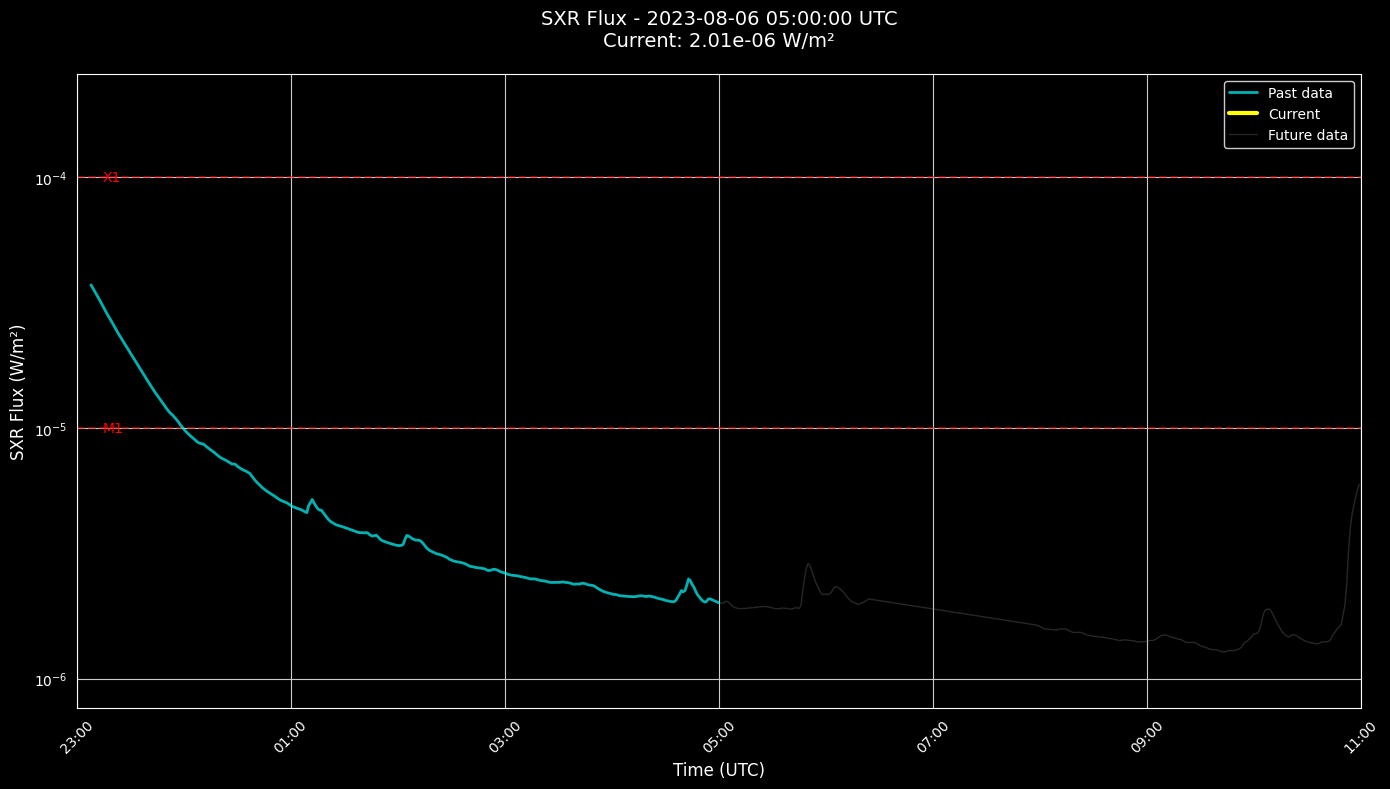

In [41]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def create_sxr_movie(df, start_time, end_time, time_interval_minutes=5,
                     output_filename='sxr_movie.mp4', fps=10, figsize=(12, 8),
                     window_hours=6):
    """
    Create a movie from SXR flux data over a specified time range.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with 'timestamp' and 'groundtruth' columns
    start_time : str
        Start time in format "YYYY-MM-DDTHH:MM:SS"
    end_time : str
        End time in format "YYYY-MM-DDTHH:MM:SS"
    time_interval_minutes : int
        Time interval between frames in minutes (default: 5 minutes)
    output_filename : str
        Output movie filename
    fps : int
        Frames per second for the movie
    figsize : tuple
        Figure size (width, height)
    window_hours : float
        Time window to show in each frame (hours)
    """

    # Convert string times to datetime objects
    start_dt = pd.to_datetime(start_time)
    end_dt = pd.to_datetime(end_time)

    # Ensure df timestamp column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter data to the relevant time range (with some buffer for windowing)
    buffer_hours = max(window_hours, 12)  # At least 12 hours buffer
    buffer_start = start_dt - timedelta(hours=buffer_hours)
    buffer_end = end_dt + timedelta(hours=buffer_hours)

    df_filtered = df[(df['timestamp'] >= buffer_start) &
                     (df['timestamp'] <= buffer_end)].copy()
    df_filtered = df_filtered.sort_values('timestamp')

    print(f"Filtered SXR data: {len(df_filtered)} points")
    print(f"Data time range: {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")

    # Generate time stamps for animation frames
    time_stamps = []
    current_time = start_dt
    while current_time <= end_dt:
        time_stamps.append(current_time)
        current_time += timedelta(minutes=time_interval_minutes)

    print(f"Creating SXR movie with {len(time_stamps)} frames")
    print(f"Time range: {start_time} to {end_time}")
    print(f"Frame interval: {time_interval_minutes} minutes")

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Style the plot
    ax.tick_params(colors='white', which='both')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')

    # Set up labels
    ax.set_xlabel('Time (UTC)', color='white', fontsize=12)
    ax.set_ylabel('SXR Flux (W/m²)', color='white', fontsize=12)

    # Use log scale for SXR flux (typical for solar X-ray data)
    ax.set_yscale('log')

    # Set y-axis limits based on data range
    flux_min = df_filtered['groundtruth'].min()
    flux_max = df_filtered['groundtruth'].max()

    # Add some padding to y-limits
    y_range = flux_max / flux_min
    ax.set_ylim(flux_min / (y_range ** 0.1), flux_max * (y_range ** 0.1))

    # Add horizontal lines for flare class thresholds (if applicable)
    # These are typical GOES SXR flux thresholds
    flare_levels = {
        'C1': 1e-6,
        'M1': 1e-5,
        'X1': 1e-4
    }

    for level_name, level_value in flare_levels.items():
        if flux_min <= level_value <= flux_max:
            ax.axhline(y=level_value, color='red', linestyle='--', alpha=0.5)
            ax.text(0.02, level_value, f'{level_name}', transform=ax.get_yaxis_transform(),
                   color='red', fontsize=10, verticalalignment='center')

    # Initialize empty line objects
    line_past, = ax.plot([], [], 'cyan', linewidth=2, alpha=0.7, label='Past data')
    line_current, = ax.plot([], [], 'yellow', linewidth=3, label='Current')
    line_future, = ax.plot([], [], 'gray', linewidth=1, alpha=0.3, label='Future data')

    # Add legend
    ax.legend(loc='upper right', facecolor='black', edgecolor='white',
              labelcolor='white', fontsize=10)

    # Title
    title = ax.set_title(f'SXR Flux - {time_stamps[0].strftime("%Y-%m-%d %H:%M:%S")} UTC',
                        color='white', fontsize=14, pad=20)

    def animate(frame):
        """Animation function that updates each frame"""
        try:
            current_frame_time = time_stamps[frame]

            # Define time windows
            window_delta = timedelta(hours=window_hours)
            plot_start = current_frame_time - window_delta
            plot_end = current_frame_time + window_delta

            # Get data for this time window
            window_data = df_filtered[
                (df_filtered['timestamp'] >= plot_start) &
                (df_filtered['timestamp'] <= plot_end)
            ].copy()

            if len(window_data) == 0:
                print(f"No data for frame {frame}")
                return [line_past, line_current, line_future, title]

            # Split data into past, current, and future
            past_data = window_data[window_data['timestamp'] <= current_frame_time]
            future_data = window_data[window_data['timestamp'] > current_frame_time]

            # Update past data line
            if len(past_data) > 0:
                line_past.set_data(past_data['timestamp'], past_data['groundtruth'])
            else:
                line_past.set_data([], [])

            # Update current point (highlight the current time)
            current_point = window_data[
                window_data['timestamp'] <= current_frame_time
            ]
            if len(current_point) > 0:
                current_value = current_point.iloc[-1]
                line_current.set_data([current_value['timestamp']],
                                    [current_value['groundtruth']])
            else:
                line_current.set_data([], [])

            # Update future data line
            if len(future_data) > 0:
                line_future.set_data(future_data['timestamp'], future_data['groundtruth'])
            else:
                line_future.set_data([], [])

            # Update x-axis limits
            ax.set_xlim(plot_start, plot_end)

            # Format x-axis
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, color='white')

            # Update title
            title.set_text(f'SXR Flux - {current_frame_time.strftime("%Y-%m-%d %H:%M:%S")} UTC')

            # Add current flux value to title
            if len(current_point) > 0:
                current_flux = current_point.iloc[-1]['groundtruth']
                flux_str = f"{current_flux:.2e}"
                title.set_text(f'SXR Flux - {current_frame_time.strftime("%Y-%m-%d %H:%M:%S")} UTC\n'
                             f'Current: {flux_str} W/m²')

            if frame % 10 == 0:  # Print progress every 10 frames
                print(f"Processing SXR frame {frame+1}/{len(time_stamps)}: "
                      f"{current_frame_time.strftime('%Y-%m-%d %H:%M:%S')}")

            return [line_past, line_current, line_future, title]

        except Exception as e:
            print(f"Error processing SXR frame {frame}: {e}")
            return [line_past, line_current, line_future, title]

    # Create the animation
    print("Creating SXR animation...")
    anim = animation.FuncAnimation(fig, animate, frames=len(time_stamps),
                                 interval=1000/fps, blit=False, repeat=True)

    # Save the movie
    print(f"Saving SXR movie to {output_filename}...")
    try:
        # For MP4 output (requires ffmpeg)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, metadata=dict(artist='SXR Movie'), bitrate=1800)
        anim.save(output_filename, writer=writer, dpi=150)
        print(f"SXR movie saved successfully as {output_filename}")

    except Exception as e:
        print(f"Error saving MP4: {e}")
        # Try saving as GIF instead
        gif_filename = output_filename.replace('.mp4', '.gif')
        print(f"Trying to save as GIF: {gif_filename}")
        try:
            anim.save(gif_filename, writer='pillow', fps=fps//2)
            print(f"GIF saved successfully as {gif_filename}")
        except Exception as e2:
            print(f"Error saving GIF: {e2}")

    plt.tight_layout()
    return anim

# Usage example
if __name__ == "__main__":
    # Assuming you have your dataframe 'df' with 'timestamp' and 'groundtruth' columns
    # Match the same time range as your AIA movie
    start_time = "2023-08-05T14:00:00"
    end_time = "2023-08-06T05:00:00"

    # Create the SXR movie
    sxr_animation = create_sxr_movie(
        df=df,  # Your dataframe with timestamp and groundtruth columns
        start_time=start_time,
        end_time=end_time,
        time_interval_minutes=5,  # Same as AIA movie for synchronization
        output_filename='/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/sxr_flux.mp4',
        fps=10,  # Same as AIA movie
        figsize=(14, 8),
        window_hours=6  # Show 6 hours of data in each frame
    )

    plt.show()

Filtered SXR data: 1951 points
Data time range: 2023-08-05 02:00:00 to 2023-08-06 17:00:00
Creating SXR movie with 451 frames
Time range: 2023-08-05T14:00:00 to 2023-08-06T05:00:00
Frame interval: 2 minutes
Creating SXR animation...
Saving SXR movie to /home/griffingoodwin/2025-HL-Flaring-MEGS-AI/sxr_flux.mp4...
Processing SXR frame 1/451: 2023-08-05 14:00:00
Processing SXR frame 1/451: 2023-08-05 14:00:00
Processing SXR frame 11/451: 2023-08-05 14:20:00
Processing SXR frame 21/451: 2023-08-05 14:40:00
Processing SXR frame 31/451: 2023-08-05 15:00:00
Processing SXR frame 41/451: 2023-08-05 15:20:00
Processing SXR frame 51/451: 2023-08-05 15:40:00
Processing SXR frame 61/451: 2023-08-05 16:00:00
Processing SXR frame 71/451: 2023-08-05 16:20:00
Processing SXR frame 81/451: 2023-08-05 16:40:00
Processing SXR frame 91/451: 2023-08-05 17:00:00
Processing SXR frame 101/451: 2023-08-05 17:20:00
Processing SXR frame 111/451: 2023-08-05 17:40:00
Processing SXR frame 121/451: 2023-08-05 18:00:00

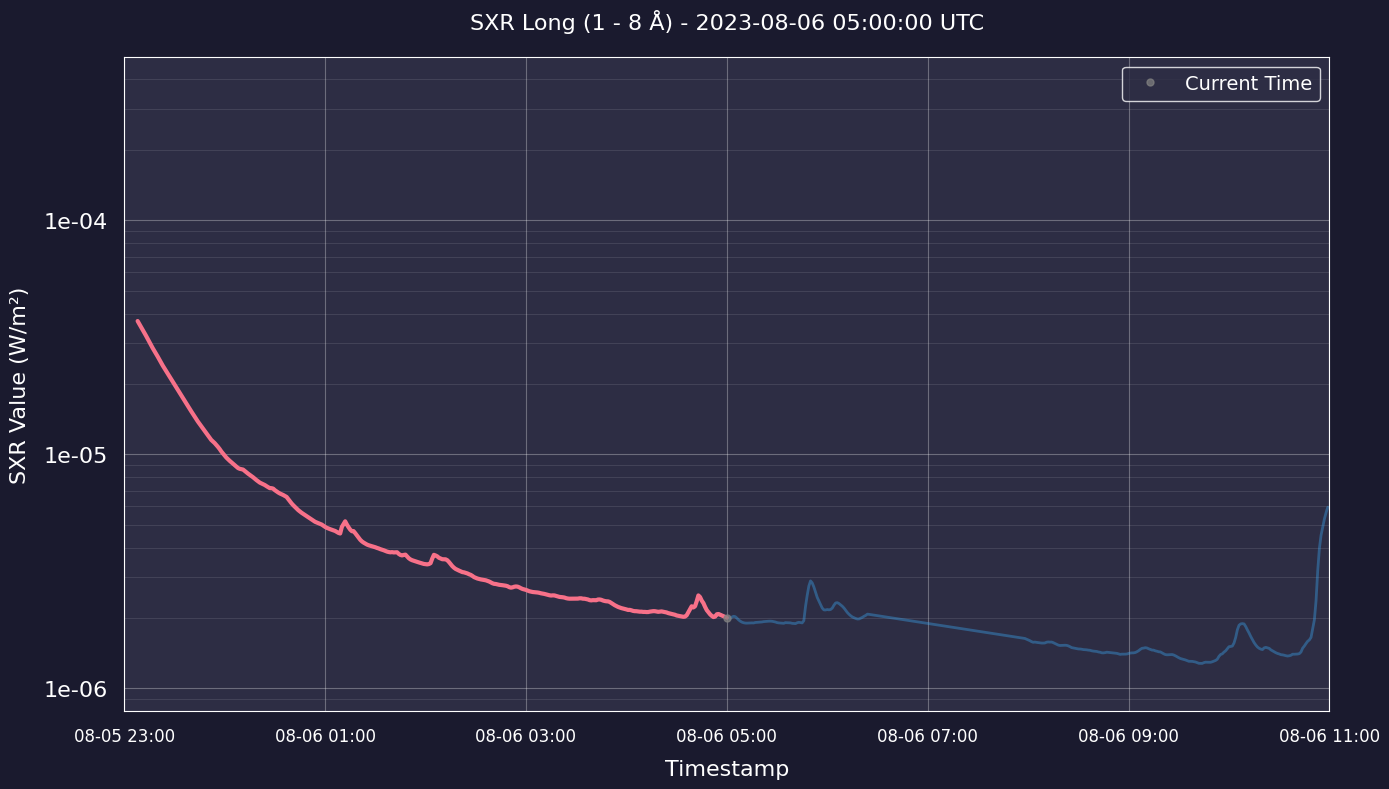

In [48]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator, FormatStrFormatter
import seaborn as sns

def create_sxr_movie(df, start_time, end_time, time_interval_minutes=5,
                     output_filename='sxr_movie.mp4', fps=10, figsize=(12, 8),
                     window_hours=6):
    """
    Create a movie from SXR flux data over a specified time range.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with 'timestamp' and 'groundtruth' columns
    start_time : str
        Start time in format "YYYY-MM-DDTHH:MM:SS"
    end_time : str
        End time in format "YYYY-MM-DDTHH:MM:SS"
    time_interval_minutes : int
        Time interval between frames in minutes (default: 5 minutes)
    output_filename : str
        Output movie filename
    fps : int
        Frames per second for the movie
    figsize : tuple
        Figure size (width, height)
    window_hours : float
        Time window to show in each frame (hours)
    """

    # Convert string times to datetime objects
    start_dt = pd.to_datetime(start_time)
    end_dt = pd.to_datetime(end_time)

    # Ensure df timestamp column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter data to the relevant time range (with some buffer for windowing)
    buffer_hours = max(window_hours, 12)  # At least 12 hours buffer
    buffer_start = start_dt - timedelta(hours=buffer_hours)
    buffer_end = end_dt + timedelta(hours=buffer_hours)

    df_filtered = df[(df['timestamp'] >= buffer_start) &
                     (df['timestamp'] <= buffer_end)].copy()
    df_filtered = df_filtered.sort_values('timestamp')

    print(f"Filtered SXR data: {len(df_filtered)} points")
    print(f"Data time range: {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")

    # Generate time stamps for animation frames
    time_stamps = []
    current_time = start_dt
    while current_time <= end_dt:
        time_stamps.append(current_time)
        current_time += timedelta(minutes=time_interval_minutes)

    print(f"Creating SXR movie with {len(time_stamps)} frames")
    print(f"Time range: {start_time} to {end_time}")
    print(f"Frame interval: {time_interval_minutes} minutes")

    # Set up matplotlib style to match your plotting style
    plt.style.use('dark_background')
    sns.set_palette("husl")

    # Set up the figure and axis with your color scheme
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#1a1a2e')
    ax.set_facecolor('#2d2d44')

    # Style the plot to match your formatting
    ax.tick_params(colors='white', which='both')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')

    # Set up labels with your font sizes
    ax.set_xlabel('Timestamp', color='white', fontsize=16, labelpad=10)
    ax.set_ylabel('SXR Value (W/m²)', color='white', fontsize=16, labelpad=10)

    # Use log scale for SXR flux (typical for solar X-ray data)
    ax.set_yscale('log')

    # Set y-axis limits and formatting to match your style
    ax.set_ylim([8e-7, 5e-4])

    # Major ticks
    ax.set_yticks([1e-6, 1e-5, 1e-4])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))

    # Minor ticks
    minor_locator = LogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100)
    ax.yaxis.set_minor_locator(minor_locator)

    # Style ticks to match your formatting
    ax.tick_params(axis='y', which='minor', length=5, width=1, color='white', labelsize=10)
    ax.tick_params(axis='x', labelsize=16, length=8, width=2, colors='white')
    ax.tick_params(axis='y', which='major', labelsize=16, length=8, width=2, colors='white')

    # Grid - enable minor grid for better visibility
    ax.grid(True, alpha=0.3, which='major')
    ax.grid(True, alpha=0.1, which='minor')

    # Remove the flare level lines to match your clean style

    # Get seaborn husl color palette
    colors = sns.color_palette("husl", 3)

    # Initialize empty line objects with husl colors

    line_future, = ax.plot([], [], color=colors[2], linewidth=2, alpha=0.4)
    line_past, = ax.plot([], [], color=colors[0], linewidth=3, alpha=1)
    line_current, = ax.plot([], [], 'o', color= "grey" , markersize=5,alpha=.75, label='Current Time')

    # Add legend with your styling
    ax.legend(loc='upper right', facecolor='#2d2d44', edgecolor='white',
              labelcolor='white', fontsize=14)

    # Title with your styling
    title = ax.set_title(f'SXR Long (1 - 8 Å) - {time_stamps[0].strftime("%Y-%m-%d %H:%M:%S")} UTC',
                        color='white', fontsize=16, pad=20)

    def animate(frame):
        """Animation function that updates each frame"""
        try:
            current_frame_time = time_stamps[frame]

            # Define time windows
            window_delta = timedelta(hours=window_hours)
            plot_start = current_frame_time - window_delta
            plot_end = current_frame_time + window_delta

            # Get data for this time window
            window_data = df_filtered[
                (df_filtered['timestamp'] >= plot_start) &
                (df_filtered['timestamp'] <= plot_end)
            ].copy()

            if len(window_data) == 0:
                print(f"No data for frame {frame}")
                return [line_past, line_current, line_future, title]

            # Split data into past, current, and future
            past_data = window_data[window_data['timestamp'] <= current_frame_time]
            future_data = window_data[window_data['timestamp'] > current_frame_time - timedelta(minutes=20)]

            # Update past data line
            if len(past_data) > 0:
                line_past.set_data(past_data['timestamp'], past_data['groundtruth'])
            else:
                line_past.set_data([], [])

            # Update current point (highlight the current time)
            current_point = window_data[
                window_data['timestamp'] <= current_frame_time
            ]
            if len(current_point) > 0:
                current_value = current_point.iloc[-1]
                line_current.set_data([current_value['timestamp']],
                                    [current_value['groundtruth']])
            else:
                line_current.set_data([], [])

            # Update future data line
            if len(future_data) > 0:
                line_future.set_data(future_data['timestamp'], future_data['groundtruth'])
            else:
                line_future.set_data([], [])

            # Update x-axis limits
            ax.set_xlim(plot_start, plot_end)

            # Format x-axis with better time formatting
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, color='white', fontsize=12)

            # Update title to match your style
            title.set_text(f'SXR Long (1 - 8 Å) - {current_frame_time.strftime("%Y-%m-%d %H:%M:%S")} UTC')

            # Add current flux value to title
            if len(current_point) > 0:
                current_flux = current_point.iloc[-1]['groundtruth']

            if frame % 10 == 0:  # Print progress every 10 frames
                print(f"Processing SXR frame {frame+1}/{len(time_stamps)}: "
                      f"{current_frame_time.strftime('%Y-%m-%d %H:%M:%S')}")

            return [line_past, line_current, line_future, title]

        except Exception as e:
            print(f"Error processing SXR frame {frame}: {e}")
            return [line_past, line_current, line_future, title]

    # Create the animation
    print("Creating SXR animation...")
    anim = animation.FuncAnimation(fig, animate, frames=len(time_stamps),
                                 interval=1000/fps, blit=False, repeat=True)

    # Save the movie
    print(f"Saving SXR movie to {output_filename}...")
    try:
        # For MP4 output (requires ffmpeg)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, metadata=dict(artist='SXR Movie'), bitrate=1800)
        anim.save(output_filename, writer=writer, dpi=150)
        print(f"SXR movie saved successfully as {output_filename}")

    except Exception as e:
        print(f"Error saving MP4: {e}")
        # Try saving as GIF instead
        gif_filename = output_filename.replace('.mp4', '.gif')
        print(f"Trying to save as GIF: {gif_filename}")
        try:
            anim.save(gif_filename, writer='pillow', fps=fps//2)
            print(f"GIF saved successfully as {gif_filename}")
        except Exception as e2:
            print(f"Error saving GIF: {e2}")

    plt.tight_layout()
    return anim

# Usage example
if __name__ == "__main__":
    # Assuming you have your dataframe 'df' with 'timestamp' and 'groundtruth' columns
    # Match the same time range as your AIA movie
    start_time = "2023-08-05T14:00:00"
    end_time = "2023-08-06T05:00:00"

    # Create the SXR movie
    sxr_animation = create_sxr_movie(
        df=df,  # Your dataframe with timestamp and groundtruth columns
        start_time=start_time,
        end_time=end_time,
        time_interval_minutes=2,  # Same as AIA movie for synchronization
        output_filename='/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/sxr_flux.mp4',
        fps=15,  # Same as AIA movie
        figsize=(14, 8),
        window_hours=6  # Show 6 hours of data in each frame
    )

    plt.show()

In [55]:
#!/usr/bin/env python3
"""
High-Quality MP4 to GIF Converter

This script converts MP4 videos to high-quality GIFs using FFmpeg.
Interactive version that prompts for all settings.

Requirements:
- FFmpeg installed on your system
- Python 3.6+

Usage:
    python mp4_to_gif.py
"""

import subprocess
import sys
import os
from pathlib import Path

def check_ffmpeg():
    """Check if FFmpeg is installed and accessible."""
    try:
        subprocess.run(['ffmpeg', '-version'], capture_output=True, check=True)
        return True
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

def get_video_info(input_file):
    """Get basic information about the input video."""
    try:
        cmd = [
            'ffprobe', '-v', 'quiet', '-print_format', 'json', '-show_format',
            '-show_streams', str(input_file)
        ]
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        return result.stdout
    except subprocess.CalledProcessError:
        return None

def convert_mp4_to_gif(input_file, output_file, fps=15, width=None, quality='high',
                      start_time=None, duration=None):
    """
    Convert MP4 to GIF with high quality settings.

    Args:
        input_file (str): Path to input MP4 file
        output_file (str): Path to output GIF file
        fps (int): Frame rate for the GIF (default: 15)
        width (int): Width in pixels (height will be auto-calculated)
        quality (str): Quality preset ('high', 'medium', 'low')
        start_time (str): Start time (e.g., '00:00:10' for 10 seconds)
        duration (str): Duration (e.g., '00:00:05' for 5 seconds)
    """

    # Quality presets
    quality_settings = {
        'high': {'colors': 256, 'dither': 'bayer:bayer_scale=5'},
        'medium': {'colors': 128, 'dither': 'bayer:bayer_scale=3'},
        'low': {'colors': 64, 'dither': 'bayer:bayer_scale=1'}
    }

    settings = quality_settings.get(quality, quality_settings['high'])

    # Build the FFmpeg command for high-quality GIF conversion
    # This uses a two-pass approach: generate palette first, then create GIF

    # Step 1: Generate optimal color palette
    palette_cmd = ['ffmpeg', '-y', '-i', str(input_file)]

    if start_time:
        palette_cmd.extend(['-ss', start_time])
    if duration:
        palette_cmd.extend(['-t', duration])

    # Video filters for palette generation
    vf_palette = f'fps={fps}'
    if width:
        vf_palette += f',scale={width}:-1:flags=lanczos'
    vf_palette += f',palettegen=max_colors={settings["colors"]}:reserve_transparent=0'

    palette_cmd.extend(['-vf', vf_palette, '/tmp/palette.png'])

    print("Generating optimal color palette...")
    try:
        subprocess.run(palette_cmd, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print(f"Error generating palette: {e}")
        return False

    # Step 2: Create GIF using the generated palette
    gif_cmd = ['ffmpeg', '-y', '-i', str(input_file), '-i', '/tmp/palette.png']

    if start_time:
        gif_cmd.extend(['-ss', start_time])
    if duration:
        gif_cmd.extend(['-t', duration])

    # Video filters for GIF creation
    vf_gif = f'fps={fps}'
    if width:
        vf_gif += f',scale={width}:-1:flags=lanczos'
    vf_gif += f'[x];[x][1:v]paletteuse=dither={settings["dither"]}'

    gif_cmd.extend(['-lavfi', vf_gif, str(output_file)])

    print(f"Converting to GIF with {quality} quality...")
    try:
        subprocess.run(gif_cmd, check=True, capture_output=True)
        # Clean up temporary palette file
        if os.path.exists('/tmp/palette.png'):
            os.remove('/tmp/palette.png')
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error creating GIF: {e}")
        if os.path.exists('/tmp/palette.png'):
            os.remove('/tmp/palette.png')
        return False

def main(input_file, output_file=None, fps=15, width=None, quality='high',
         start_time=None, duration=None):
    """
    Convert MP4 to GIF with specified parameters.

    Args:
        input_file (str): Path to input MP4 file
        output_file (str): Path to output GIF file (optional, auto-generated if None)
        fps (int): Frame rate for the GIF (default: 15)
        width (int): Width in pixels (height will be auto-calculated, optional)
        quality (str): Quality preset ('high', 'medium', 'low', default: 'high')
        start_time (str): Start time (e.g., '00:00:10', optional)
        duration (str): Duration (e.g., '00:00:05', optional)

    Returns:
        bool: True if conversion successful, False otherwise
    """
    # Check if FFmpeg is installed
    if not check_ffmpeg():
        print("Error: FFmpeg is not installed or not found in PATH.")
        print("Please install FFmpeg: https://ffmpeg.org/download.html")
        return False

    # Validate input file
    input_path = Path(input_file)
    if not input_path.exists():
        print(f"Error: Input file '{input_file}' does not exist.")
        return False

    # Generate output filename if not provided
    if output_file:
        output_path = Path(output_file)
        if not output_path.suffix:
            output_path = output_path.with_suffix('.gif')
    else:
        output_path = input_path.with_suffix('.gif')

    # Ensure output directory exists
    output_path.parent.mkdir(parents=True, exist_ok=True)

    print(f"\n=== Conversion Settings ===")
    print(f"Input: {input_path}")
    print(f"Output: {output_path}")
    print(f"Quality: {quality}")
    print(f"Frame rate: {fps} fps")
    if width:
        print(f"Width: {width}px")
    else:
        print("Width: Original size")
    if start_time:
        print(f"Start time: {start_time}")
    if duration:
        print(f"Duration: {duration}")
    print()

    # Convert the video
    success = convert_mp4_to_gif(
        input_file=input_path,
        output_file=output_path,
        fps=fps,
        width=width,
        quality=quality,
        start_time=start_time,
        duration=duration
    )

    if success:
        file_size = output_path.stat().st_size / (1024 * 1024)  # Size in MB
        print(f"✅ Conversion successful!")
        print(f"📁 Output file: {output_path}")
        print(f"📊 File size: {file_size:.2f} MB")
        return True
    else:
        print("❌ Conversion failed!")
        return False

if __name__ == "__main__":
    # Example usage - you can modify these parameters
    success = main(
        input_file="/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/AIA_video_with_uncertainties.mp4",  # Replace with your MP4 file path
        output_file="/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/output.gif",  # Optional: specify output name
        fps=15,  # Frame rate
        width=800,  # Optional: resize width
        quality="high",  # 'high', 'medium', or 'low'
        start_time="00:00:30",  # Optional: e.g., "00:00:10"
        duration=None  # Optional: e.g., "00:00:05"
    )

    if not success:
        sys.exit(1)


=== Conversion Settings ===
Input: /home/griffingoodwin/2025-HL-Flaring-MEGS-AI/AIA_video_with_uncertainties.mp4
Output: /home/griffingoodwin/2025-HL-Flaring-MEGS-AI/output.gif
Quality: high
Frame rate: 15 fps
Width: 800px
Start time: 00:00:30

Generating optimal color palette...
Converting to GIF with high quality...
Error creating GIF: Command '['ffmpeg', '-y', '-i', '/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/AIA_video_with_uncertainties.mp4', '-i', '/tmp/palette.png', '-ss', '00:00:30', '-lavfi', 'fps=15,scale=800:-1:flags=lanczos[x];[x][1:v]paletteuse=dither=bayer:bayer_scale=5', '/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/output.gif']' returned non-zero exit status 1.
❌ Conversion failed!


SystemExit: 1

/opt/conda/envs/Flare_detection/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
